## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [4]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [6]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [8]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [9]:
### Process and observation noise
σx = 1e-1
σy = 1.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [11]:
# Number of runs
Ne = 500

# Time span
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz63!, zeros(Nx), tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Create cache to store the different final solutions

In [12]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [13]:
J = ceil(Int64, (tf-t0)/Δtobs)
@inbounds for i=1:Ne
    xtmp = rand(π0)
    for j=1:J
        tspan = (t0 + (j-1)*model.Δtobs, t0 + j*model.Δtobs)
        prob = remake(prob, tspan = tspan, u0 = xtmp)
        sol = solve(prob, Tsit5(), dt = Δtdyn, dense = false, save_everystep = false)
        xtmp .= copy(sol.u[end]) 
        # Add process noise
        model.ϵx(xtmp)
    end
    
    # Store the state
    X[Ny+1:Ny+Nx,i] .= copy(xtmp)
end
# Generate the observations
observe(h, X, tf, Ny, Nx)

# Apply the observation noise
ϵy(X, 1, Ny)

In [14]:
# writedlm( "lorenzdata.csv",  X, ',')
X = readdlm( "lorenzdata.csv",  ',')

6×500 Array{Float64,2}:
 12.6981    0.930478   3.98214  13.6515  …   5.38257    9.40037  -13.654
  8.37203   1.62649    5.75284  13.2089      0.775109   3.96774  -11.2277
 36.521    10.9611    17.4395   34.3492     29.3109    33.9116    36.3547
 12.6979    0.929687   3.98188  13.6506      5.38174    9.40014  -13.6549
  8.37175   1.62558    5.75274  13.2087      0.774492   3.96771  -11.2286
 36.5206   10.9604    17.4391   34.3489  …  29.3107    33.9112    36.354

In [15]:
# Initialize the map
m = 10
S = HermiteMap(m, X; diag = true, α = 1.0e-4)

HermiteMap(10, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [16]:
# plt = plot(layout = grid(6,1), size = (400, 800))

# for i=1:6
#       histogram!(plt[i,1], sort(transform(X)[i,:]), bins = 100; normalize = :pdf, legend = false)     
# end
# plt
# savefig("normalized_histogram.pdf")

The optimization works up to 22 active features, after the Cholesky decomposition crashes.

In [17]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = false, hessprecond = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


 31.926392 seconds (74.23 M allocations: 6.438 GiB, 4.39% gc time)


HermiteMap(10, 6, LinearTransform(6, [0.4147432940129076, 0.16516928040533463, 23.185696156541045, 0.4142537177229937, 0.16468411727530424, 23.185208293342406], [7.605649175105361 0.0 … 0.0 0.0; 0.0 8.937206142197835 … 0.0 0.0; … ; 0.0 0.0 … 8.937225951689017 0.0; 0.0 0.0 … 0.0 8.356337886751735], true), MapComponent[Map component of dimension 1 with Nψ 8 active features
, Map component of dimension 2 with Nψ 10 active features
, Map component of dimension 3 with Nψ 10 active features
, Map component of dimension 4 with Nψ 10 active features
, Map component of dimension 5 with Nψ 10 active features
, Map component of dimension 6 with Nψ 10 active features
])

In [18]:
# Conditioning number of the basis evaluation on the different samples
cond(evaluate_basis(S[1].I.f.f,  transform(X[1:1,:])))

145.69621986411786

In [19]:
stor = Storage(S[1].I.f, transform(X[1:1,:]))
q = QRscaling(stor)

QRscaling([-22.36067977499789 -0.7192395394428297 … 3.487316104131349 1.263135913615813; 0.0 -22.34910947856541 … -0.5960342430510772 2.231850829980256; … ; 0.0 0.0 … 2.3567764691736994 0.2627395987615587; 0.0 0.0 … 0.0 1.0976714496580928], [-0.04472135954999581 0.0014392237899610878 … 0.14271114743145338 -0.04496039352748301; 0.0 -0.0447445121229139 … -0.03043090009552689 0.6689149400212299; … ; 0.0 0.0 … 0.4243083775995974 -0.10156282457415762; 0.0 0.0 … 0.0 0.9110194132419898], [0.525992748576151 0.0 … 0.0 0.0; 0.0 0.3836867233680237 … 0.0 0.0; … ; 0.0 0.0 … 0.25049854676258415 0.0; 0.0 0.0 … 0.0 0.2482548267582635], [1.9011668938535267 0.0 … 0.0 0.0; 0.0 2.6062929444676732 … 0.0 0.0; … ; 0.0 0.0 … 3.992039127267965 0.0; 0.0 0.0 … 0.0 4.0281190624089795], [-11.76155541488229 -0.2759626622055458 … 0.8735676161866596 0.3135795874068345; 0.0 -8.575056586024003 … -0.1493057117050317 0.554067741147035; … ; 0.0 0.0 … 0.5903690805722659 0.06522637357308642; 0.0 0.0 … 0.0 0.2725022355723618

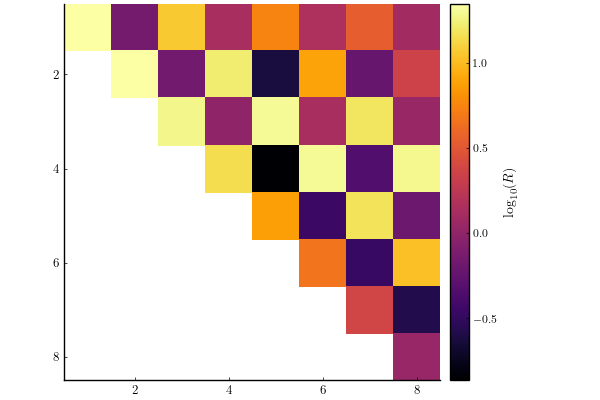

In [20]:
heatmap(log10.(abs.(q.R)), yflip =true, ratio = 1, colorbartitle = L"\log_{10}(R)")
# savefig("R_matrix.pdf")

In [21]:
cond(q.R)

111.73006949193427

In [22]:
getcoeff(S[3])

10-element Array{Float64,1}:
  33.959096143823366
 -17.58546716612034
 -16.235949022832965
   8.813689966195863
  -1.7050985733016515
  -3.56942316726535
   5.585283777672776
   0.8216500288395603
   2.0077806981409916
  -0.23594739642931903

In [23]:
cond(evaluate_basis(S[6].I.f.f, X[1:6,:]))

3.1025640154972476e12

In [24]:
P = zeros(ncoeff(S[1]), ncoeff(S[1]))
precond!(P, getcoeff(S[1]), stor, S[1], X[1:1,:])

Pqr = zeros(ncoeff(S[1]), ncoeff(S[1]))
qrprecond!(Pqr, q.U*getcoeff(S[1]), q, stor, S[1], X[1:1,:])

8×8 Array{Float64,2}:
  0.000855228   2.89794e-5    0.000445319  …  -0.0192592    0.0102198
  2.89794e-5    0.000477728   4.98451e-5      -0.00618659   0.0332823
  0.000445319   4.98451e-5    0.000963436     -0.0223839    0.0286507
  0.000119766  -0.000450165  -0.000285952      0.0105203   -0.113838
  0.0038021     0.000794907   0.00320292      -0.209096     0.192488
 -0.000917555  -0.00482533   -0.00372891   …   0.206165    -1.30508
 -0.0192592    -0.00618659   -0.0223839        1.29411     -1.55719
  0.0102198     0.0332823     0.0286507       -1.55719      8.43712

In [25]:
cond(P)

61.59830326535166

In [26]:
cond(Pqr)

31758.93211493227

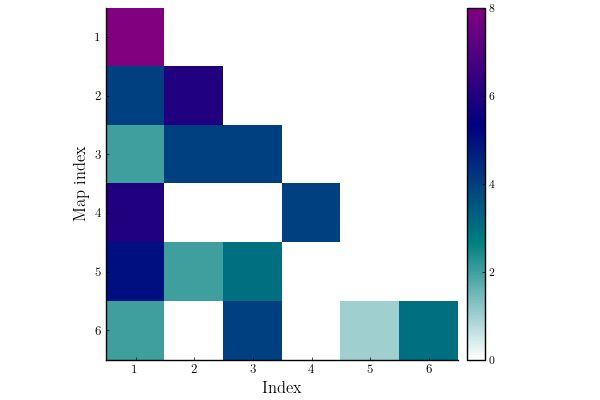

In [27]:
plot(S)

In [28]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
     1.73124e13      5.55725e7  54644.3        …   6611.24    20850.6
     5.55725e7       4.15051e7  16702.7           46707.8         0.0
 54644.3         16702.7            9.76328e9        45.8171      8.8913e9
     1.71926e13      0.0            0.0               0.0         0.0
  6611.24        46707.8           45.8171        84023.8        25.2583
 20850.6             0.0            8.8913e9   …     25.2583      9.14959e9

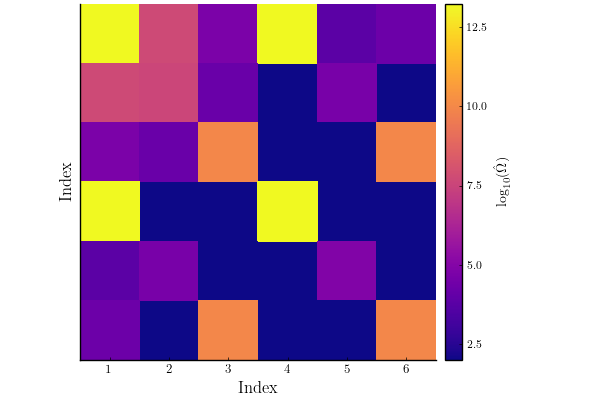

In [29]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (2.0, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

The rest is work in progress

Set initial condition of the true system

In [30]:
x0 = rand(model.π0);

In [31]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [32]:
Ne = 500 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×500 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.254923   -0.869101  -0.624306  …  1.07668  -1.13592   -0.237847
 -0.0893442   2.57092    1.82957      1.35769  -0.489433   0.997558
  2.34135     1.33265    0.912222     1.09895  -2.64794   -0.609331

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [33]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)
tspin = 10.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

100

In [34]:
Xspin = seqassim(F, data, Tspin, model.ϵx, enkf, deepcopy(X), model.Ny, model.Nx, t0);

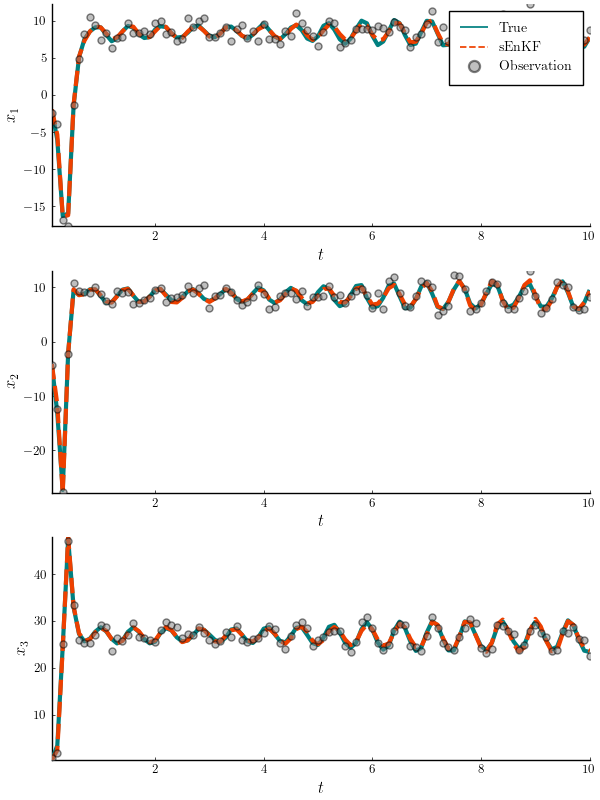

In [35]:
nb = 1
ne = Tspin
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xspin)[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

Define the stochastic map filter `smf`, based on the `HermiteMap` `S`. 

In [108]:
X0 = vcat(zeros(Ny, Ne), Xspin[end])

# Add process noise
model.ϵx(X0, Ny+1, Ny+Nx)

# Generate the observations
observe(h, X0, tspin, Ny, Nx)

# Apply the observation noise
ϵy(X0, 1, Ny)

In [109]:
m = 40
S = HermiteMap(m, X0; diag = true)

HermiteMap(40, 6, LinearTransform(6, [7.758194089731962, 9.27686152380867, 23.71016254931265, 7.7359053294520566, 9.300742476600403, 23.670460238172648], [1.017032232461467 0.0 … 0.0 0.0; 0.0 1.0028944760135003 … 0.0 0.0; … ; 0.0 0.0 … 0.29746912003706383 0.0; 0.0 0.0 … 0.0 0.39158167299879293], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [110]:
@time optimize(S, X0, "kfolds"; withqr = true, verbose = true, hessprecond = true, start = Ny+1)

1 terms - Training error: 1.4059754073652755, Validation error: 1.4657910365622602
1 terms - Training error: 1.4050370397556304, Validation error: 1.4706952138557436
2 terms - Training error: 1.3964777044148478, Validation error: 1.4486936484144812
3 terms - Training error: 1.3951964617254669, Validation error: 1.444357228358586
4 terms - Training error: 1.3925814997262227, Validation error: 1.442988506396338
5 terms - Training error: 1.3917837532194623, Validation error: 1.4442918669020588
6 terms - Training error: 1.3902290599042357, Validation error: 1.4450059852492128
7 terms - Training error: 1.3897790177004787, Validation error: 1.4466087937326906
8 terms - Training error: 1.382289989027137, Validation error: 1.4103630313546074
9 terms - Training error: 1.3817071217935395, Validation error: 1.414119437008717
10 terms - Training error: 1.3812223000161132, Validation error: 1.4129004712787174
11 terms - Training error: 1.3808383947573604, Validation error: 1.4137481828568574
12 ter

12 terms - Training error: 1.3431933148417392, Validation error: 1.5194000489759119
13 terms - Training error: 1.341400447394467, Validation error: 1.5145418187181818
14 terms - Training error: 1.3358842147758205, Validation error: 1.4889177114654812
15 terms - Training error: 1.3356817769657154, Validation error: 1.488945394914219
16 terms - Training error: 1.3356451449336062, Validation error: 1.4901000020268653
17 terms - Training error: 1.3333402710893796, Validation error: 1.5025058846684916
18 terms - Training error: 1.332725164798655, Validation error: 1.4963786348086345
19 terms - Training error: 1.329420747802981, Validation error: 1.5075589538191567
20 terms - Training error: 1.3287223258860588, Validation error: 1.495133783829792
21 terms - Training error: 1.3281177283539591, Validation error: 1.498121250200898
22 terms - Training error: 1.327825704542819, Validation error: 1.4993688443982376
23 terms - Training error: 1.3262789186318578, Validation error: 1.5032595282994459

Progress:  33%|█████████████▋                           |  ETA: 0:00:05

14 terms - Training error: 1.3653753943012206
15 terms - Training error: 1.3562092998885098
1 terms - Training error: 1.3987568552704988, Validation error: 1.494665244941368
1 terms - Training error: 1.3981167203198013, Validation error: 1.5008701156840243
2 terms - Training error: 1.3921842877628898, Validation error: 1.4908783466360993
3 terms - Training error: 1.3902276988470197, Validation error: 1.4956987140469036
4 terms - Training error: 1.3873118533757978, Validation error: 1.4895145697510794
5 terms - Training error: 1.3775046100954755, Validation error: 1.4829283012052934
6 terms - Training error: 1.3767979983730412, Validation error: 1.4846331888167665
7 terms - Training error: 1.3753647345193742, Validation error: 1.4859326987404757
8 terms - Training error: 1.3745768267175977, Validation error: 1.4945711677023827
9 terms - Training error: 1.3742082245930556, Validation error: 1.4973237943922904
10 terms - Training error: 1.3711798845123102, Validation error: 1.514217829499

7 terms - Training error: 1.1694837200603478, Validation error: 1.3530146063933381
8 terms - Training error: 1.1539395622799709, Validation error: 1.318472354805688
9 terms - Training error: 1.1496716540368148, Validation error: 1.3045996427813342
10 terms - Training error: 1.1407901615336695, Validation error: 1.3067986221115526
11 terms - Training error: 1.1382450384793497, Validation error: 1.3026951846598482
12 terms - Training error: 1.1380348232893653, Validation error: 1.3045541471451922
13 terms - Training error: 1.1294135222532085, Validation error: 1.290774020472818
14 terms - Training error: 1.1288283158550492, Validation error: 1.2892891626553482
15 terms - Training error: 1.1269030463784209, Validation error: 1.2777754432344057
16 terms - Training error: 1.1254386459152679, Validation error: 1.2798831596160132
17 terms - Training error: 1.1227711169930996, Validation error: 1.2888078311744562
18 terms - Training error: 1.1227247922466717, Validation error: 1.28922112570723

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

23 terms - Training error: 1.111533103259006
1 terms - Training error: 1.409531222610659, Validation error: 1.4515677755807255
1 terms - Training error: 1.4083870763416977, Validation error: 1.459803647673595
2 terms - Training error: 1.4075715093641301, Validation error: 1.4637289314887065
3 terms - Training error: 1.2641185330176459, Validation error: 1.3278082810813965
4 terms - Training error: 1.244085910679871, Validation error: 1.3352408412225643
5 terms - Training error: 1.242849372626857, Validation error: 1.3360382926543182
6 terms - Training error: 1.22450891987404, Validation error: 1.281731778298722
7 terms - Training error: 1.2236246083894626, Validation error: 1.2926499331938395
8 terms - Training error: 1.2188384625601216, Validation error: 1.2800966914334224
9 terms - Training error: 1.2184846362770183, Validation error: 1.2805013007420047
10 terms - Training error: 1.1851416704436393, Validation error: 1.2246627547664561
11 terms - Training error: 1.1832847209442208, V

9 terms - Training error: 1.3483049019651012, Validation error: 1.4707870219332297
10 terms - Training error: 1.3475495920894662, Validation error: 1.4725675760906356
11 terms - Training error: 1.3472573259165384, Validation error: 1.4782023772022646
12 terms - Training error: 1.3472271646594207, Validation error: 1.4774694725494752
13 terms - Training error: 1.3467151664697015, Validation error: 1.4791894343734229
14 terms - Training error: 1.3454968444792608, Validation error: 1.4825196407864574
15 terms - Training error: 1.3453539519782716, Validation error: 1.4857594377911312
16 terms - Training error: 1.3314521497513794, Validation error: 1.463741406355744
17 terms - Training error: 1.3312741467857243, Validation error: 1.4629517700435553
18 terms - Training error: 1.3271400042781138, Validation error: 1.48772443038317
19 terms - Training error: 1.3270643944139644, Validation error: 1.4874200267377053
20 terms - Training error: 1.2226868538391373, Validation error: 1.3398337863530

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


23 terms - Training error: 1.186759321477067
  7.875836 seconds (2.19 M allocations: 6.762 GiB, 4.23% gc time)


HermiteMap(40, 6, LinearTransform(6, [7.758194089731962, 9.27686152380867, 23.71016254931265, 7.7359053294520566, 9.300742476600403, 23.670460238172648], [1.017032232461467 0.0 … 0.0 0.0; 0.0 1.0028944760135003 … 0.0 0.0; … ; 0.0 0.0 … 0.29746912003706383 0.0; 0.0 0.0 … 0.0 0.39158167299879293], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 15 active features
, Map component of dimension 5 with Nψ 23 active features
, Map component of dimension 6 with Nψ 23 active features
])

In [111]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, 3*Δtobs, false)

Stochastic Map Filter with filtered = false


In [112]:
mean(evaluate(S, X0; start = Ny+1); dims = 2)

6×1 Array{Float64,2}:
  0.0
  0.0
  0.0
 -4.517878153178501e-7
 -1.9203077987516082e-5
  4.658232586682831e-5

In [116]:
cov(evaluate(S, X0; start = Ny+1); dims = 2)

6×6 Array{Float64,2}:
 0.0  0.0  0.0  0.0          0.0          0.0
 0.0  0.0  0.0  0.0          0.0          0.0
 0.0  0.0  0.0  0.0          0.0          0.0
 0.0  0.0  0.0  0.994462     0.00712562   0.0932943
 0.0  0.0  0.0  0.00712562   1.00129     -0.0676045
 0.0  0.0  0.0  0.0932943   -0.0676045    0.99604

In [117]:
Sxpush = evaluate(S, X0; start = Ny+1)[Ny+1:end,:]

3×500 Array{Float64,2}:
 -0.79204    1.00542   0.417084  …   1.59998   -1.35459   -1.29159
  0.468283   1.11068   1.16856      -0.607773  -0.580934  -1.02866
  1.00275   -0.73009  -0.563357      2.18024    0.58992    0.37722

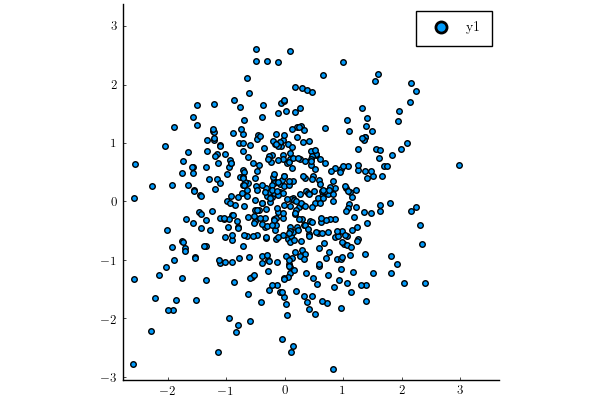

In [118]:
scatter(Sxpush[1,:], Sxpush[2,:], ratio = 1)
scatter(Sxpush[2,:], Sxpush[3,:], ratio = 1)
scatter(Sxpush[1,:], Sxpush[3,:], ratio = 1)

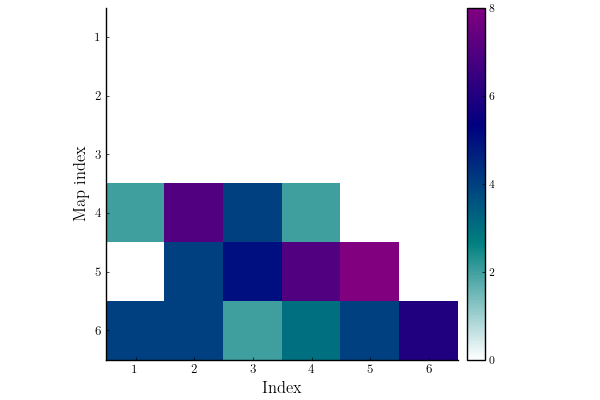

In [119]:
plot(S)

In [120]:
Xsmf = seqassim(F, data, 100, model.ϵx, smf, deepcopy(zeros(Ny, Ne), Xspin[end]), model.Ny, model.Nx, tspin+Δtobs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 

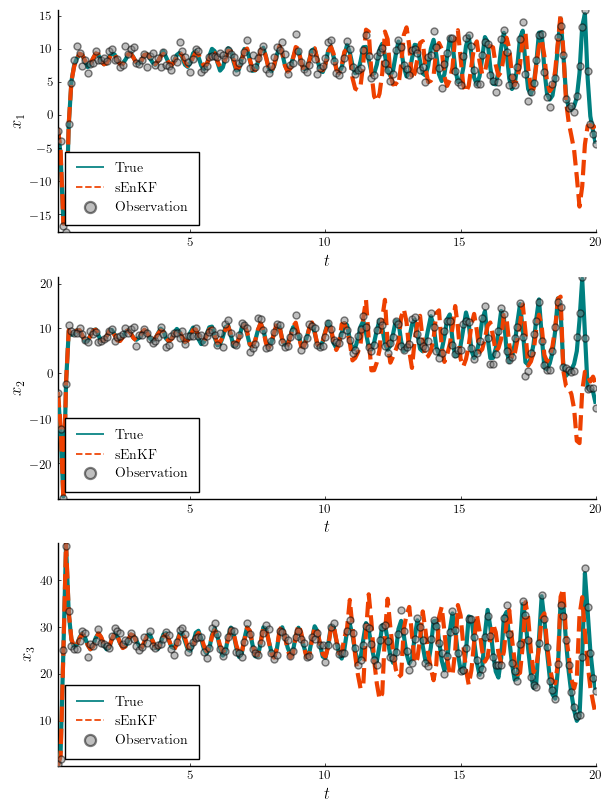

┌ Warning: /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent is not an existing directory, Revise is not watching
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:565


In [127]:
nb = 1
ne = Tspin+100
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xspin, Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

savefig("lorenz63.pdf")

In [77]:
vcat(Xspin, Xsmf)

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [133]:
# Plot the first component of the state over time
nb = 1
ne = 499
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "Stochastic Map Filter")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3×101 Array{Float64,2} at index [1, 2:1:500][39m

In [69]:
Xsmf

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/statespace/system.jl:4", UndefVarError(:TYPEDEF), Any[(top-level scope at system.jl:4, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/DA/inflation.jl:52", UndefVarError(:TYPEDFIELDS), Any[(top-level scope at inflation.jl:52, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/enkf/etkf.jl:3", UndefVarError(:TYPEDSIGNATURES), Any[(top-level scope at etkf.jl:3, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707
┌ Erro

LoadError: [91mUndefVarError: Xsmf not defined[39m

In [33]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.